# Exploratory Data Analysis

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

## Constants 

In [2]:
PATH = '../data/clean/electronics_small.csv'

DTYPES = {
    'overall':np.int16,
    'vote':np.int64,
    'verified':np.bool,
    'reviewText':np.object,
    'summary':np.object
}


In [3]:
df = pd.read_csv(PATH, parse_dates=[3],
                 low_memory=True,
                 dtype=DTYPES)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   overall     int16         
 1   vote        int64         
 2   verified    bool          
 3   reviewTime  datetime64[ns]
 4   reviewText  object        
 5   summary     object        
dtypes: bool(1), datetime64[ns](1), int16(1), int64(1), object(2)
memory usage: 100.1+ MB


In [5]:
rating_cnt = df.overall.value_counts()
vote_cnt = df.vote.value_counts()

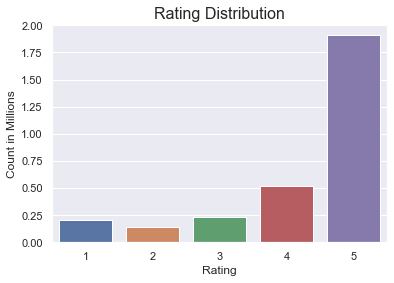

In [6]:
sns.barplot(x=rating_cnt.index, y=rating_cnt/1_000_000)
plt.title('Rating Distribution', fontsize=16)
plt.ylabel('Count in Millions')
plt.xlabel('Rating')
plt.show()

In [7]:
is_voted_value = np.array([vote_cnt[0], vote_cnt[1:].sum()])
is_vote_label = ['Not Voted', 'Voted']

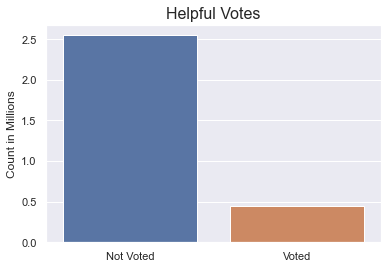

In [8]:
sns.barplot(x=is_vote_label, y=is_voted_value/1_000_000)
plt.title('Helpful Votes', fontsize=16)
plt.ylabel('Count in Millions')
plt.show()

In [9]:
year_cnt = df.reviewTime.dt.year.value_counts().sort_index()

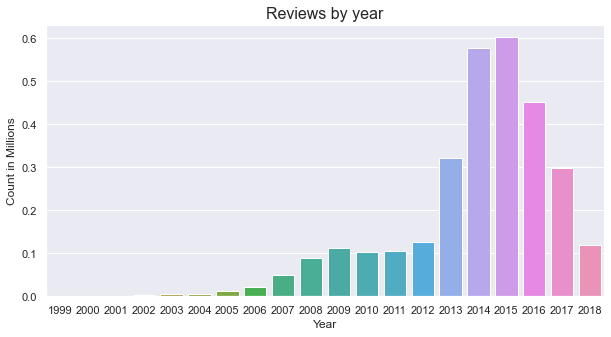

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=year_cnt.index, y=year_cnt/1_000_000, ax=ax)
plt.title('Reviews by year', fontsize=16)
plt.ylabel('Count in Millions')
plt.xlabel('Year')
plt.show()